In [1]:
# In this Notebook I show that converting a normal feedforward net to a FGN is easy
# (first over a toy 2D dataset)

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent  Thu Sep 19 11:07:20 2019
[0] GeForce GTX 1080 | 82'C,  61 % |  7901 /  8119 MB | salami(2935M) felix(625M) denys(4329M)
[1] GeForce GTX 1080 | 80'C,  63 % |  4546 /  8119 MB | felix(625M) soumi(3909M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device

torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# load MNIST data
batch_size = 1250
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size)

In [9]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
print(lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

8e-06


In [10]:
# Initialize the classic network
hidden_layer_sizes = [32,32]
drop_p = 0.2
classic_model = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p)

classic_model.to(device)

Feedforward_Classic_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Linear(in_features=32, out_features=10, bias=True)
)

In [11]:
classic_optimizer = optim.Adam(filter(lambda p: p.requires_grad, classic_model.parameters()), lr=0.001)

In [12]:
epochs = 5

In [13]:
classic_train_res = fgnh.train(classic_model, mnist_train_loader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

Epoch 0 Train set - Average loss: 1.6861, Accuracy: 29882/50000 (60%)
Test set - Average loss: 1.2778, Accuracy: 8299/10000 (83%)
Epoch 1 Train set - Average loss: 1.1524, Accuracy: 40187/50000 (80%)
Test set - Average loss: 0.8360, Accuracy: 8786/10000 (88%)
Epoch 2 Train set - Average loss: 0.8389, Accuracy: 42480/50000 (85%)
Test set - Average loss: 0.5811, Accuracy: 9041/10000 (90%)
Epoch 3 Train set - Average loss: 0.6337, Accuracy: 43794/50000 (88%)
Test set - Average loss: 0.4274, Accuracy: 9162/10000 (92%)
Epoch 4 Train set - Average loss: 0.5095, Accuracy: 44340/50000 (89%)
Test set - Average loss: 0.3386, Accuracy: 9248/10000 (92%)


In [14]:
### FGN NETWORK

In [15]:
# Initialize the fgn network
print("hidden layers:", hidden_layer_sizes)
print("drop prob:", drop_p)
# fgn specific paramshttp://localhost:1024/notebooks/Notebooks/2.3%20-%202D%20Conversion%20Comparison.ipynb#
covar_type = 'diag'
print("covariance:", covar_type)
ordinal = float(2)
print("ordinal: {0:.10f}".format(ordinal))
non_lin = torch.tanh
print("non linearity", non_lin)
noisy_centers = False
print("noisy centers:", noisy_centers)
random_eval = False
print("Random Eval", random_eval)

hidden layers: [32, 32]
drop prob: 0.2
covariance: diag
ordinal: 2.0000000000
non linearity <built-in function tanh>
noisy centers: False
Random Eval False


In [16]:
fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, 
                                     noisy_centers=noisy_centers)

fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2)
    (1): FGN_layer()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
    (4): FGN_layer()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [17]:
# What is the activity of the FGN before conversion?
fgn_test_res_traindata_pre = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res_testdata_pre = fgnh.test(fgn_model, mnist_test_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 2.6440, Accuracy: 4176/50000 (8%)
Test set - Average loss: 2.6369, Accuracy: 820/10000 (8%)


In [18]:
# convert the network
fgnl.convert_classic_to_fgn(classic_model, fgn_model)

In [19]:
# make sure performance after isnt crap
fgn_test_res_traindata_post = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res_traindata_post = fgnh.test(fgn_model, mnist_test_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 1.4232, Accuracy: 45958/50000 (92%)
Test set - Average loss: 1.4241, Accuracy: 9183/10000 (92%)


In [20]:
# switch to random eval
# shouldn't change because of the large sigma/small inv_covar
fgn_model.set_random_eval(True)
fgn_test_res_traindata_post_randomeval = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res_testndata_post_randomeval = fgnh.test(fgn_model, mnist_test_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 1.4232, Accuracy: 45958/50000 (92%)
Test set - Average loss: 1.4241, Accuracy: 9183/10000 (92%)


In [21]:
### PART 2 - adjust sigmas

In [22]:
# adjusts sigmas
# - should be fast (one epoch)
# - shouldn't impact accuracy

In [23]:
# method one: train with CENT loss but only adjust sigmas

In [24]:
# only train inv_covar
# adjust_sigmas_optimizer = optim.Adam(zip(*filter(lambda p: p[1].requires_grad and 'inv_covar' in p[0], 
#                                                  fgn_model.named_parameters()))[1], 
#                                      lr=0.001)
# adjust_sigmas_optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.001)

adjust_sigmas_optimizer = optim.RMSprop(zip(*filter(lambda p: p[1].requires_grad and 'inv_covar' in p[0], 
                                                 fgn_model.named_parameters()))[1])
adjust_sigmas_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2=0.0, lmbda_sigs=1e1*lmbda_l2)

In [25]:
fgn_model.train()
fgn_model.set_random_eval(False)

converted_train_res = fgnh.train(fgn_model, mnist_train_loader, 
                             adjust_sigmas_loss, adjust_sigmas_optimizer, epochs=1, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 2.9240, Accuracy: 36388/50000 (73%)
Test set - Average loss: 1.5444, Accuracy: 8273/10000 (83%)


In [26]:
# check accuracy with random eval
fgn_model.set_random_eval(True)
fgn_test_res_traindata_post_randomeval = fgnh.test(fgn_model, mnist_train_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res_testndata_post_randomeval = fgnh.test(fgn_model, mnist_test_loader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 1.5421, Accuracy: 41088/50000 (82%)
Test set - Average loss: 1.5343, Accuracy: 8273/10000 (83%)


fl.inv_covar
(41, 10, 32)
plotting neurons: [3 1]


<IPython.core.display.Javascript object>


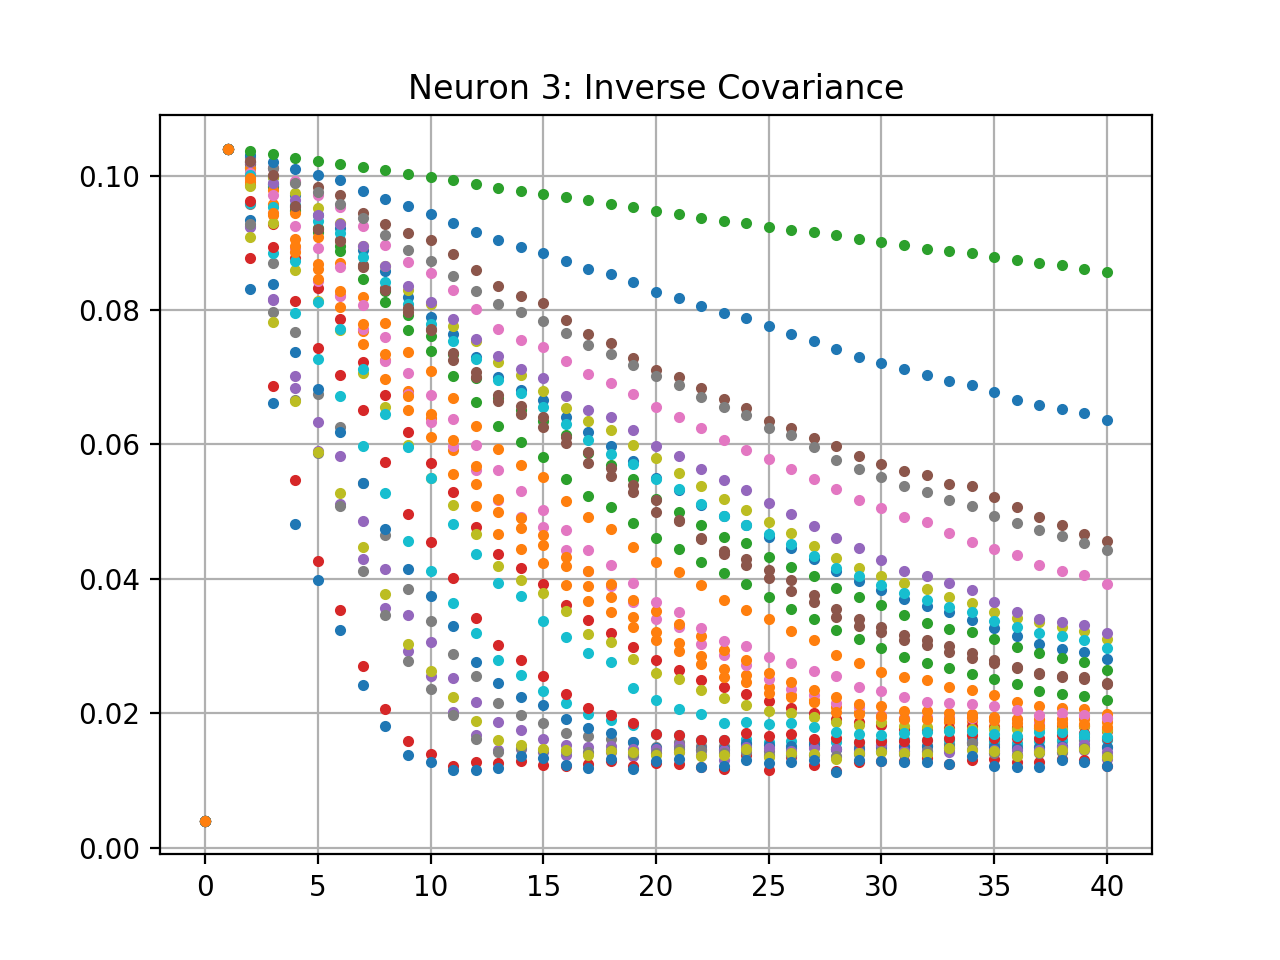

<IPython.core.display.Javascript object>


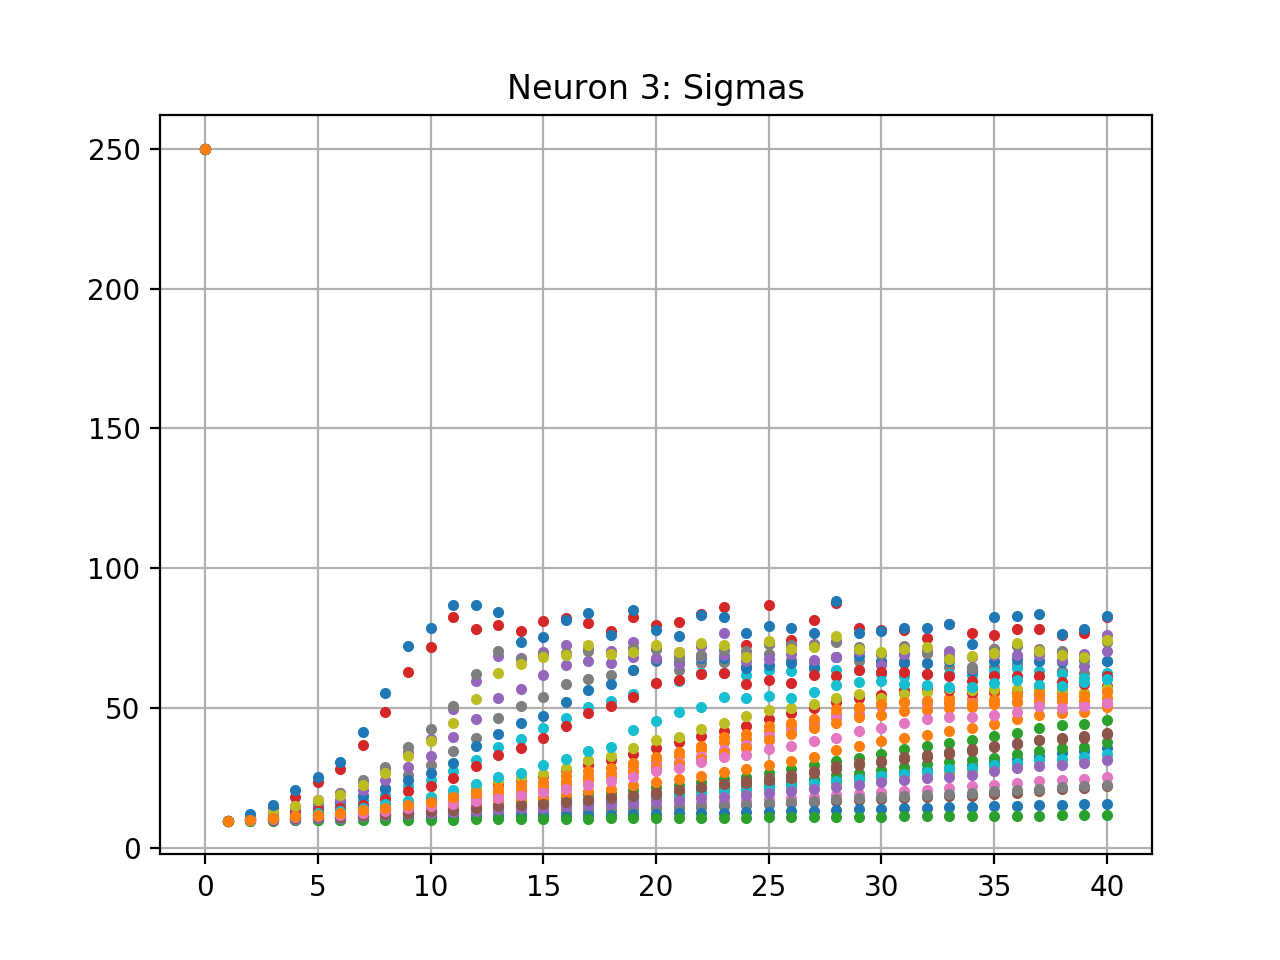

<IPython.core.display.Javascript object>


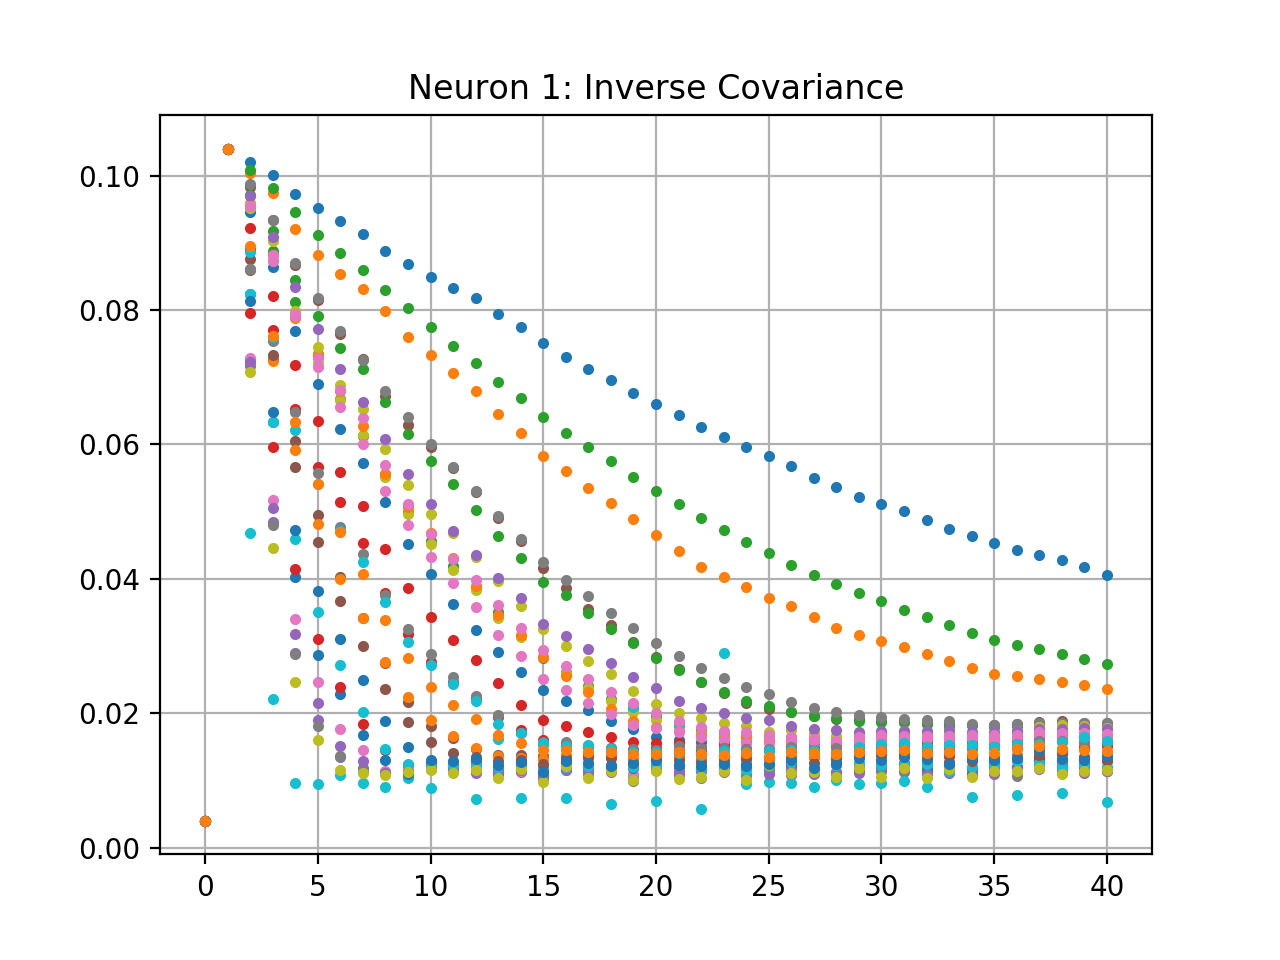

<IPython.core.display.Javascript object>


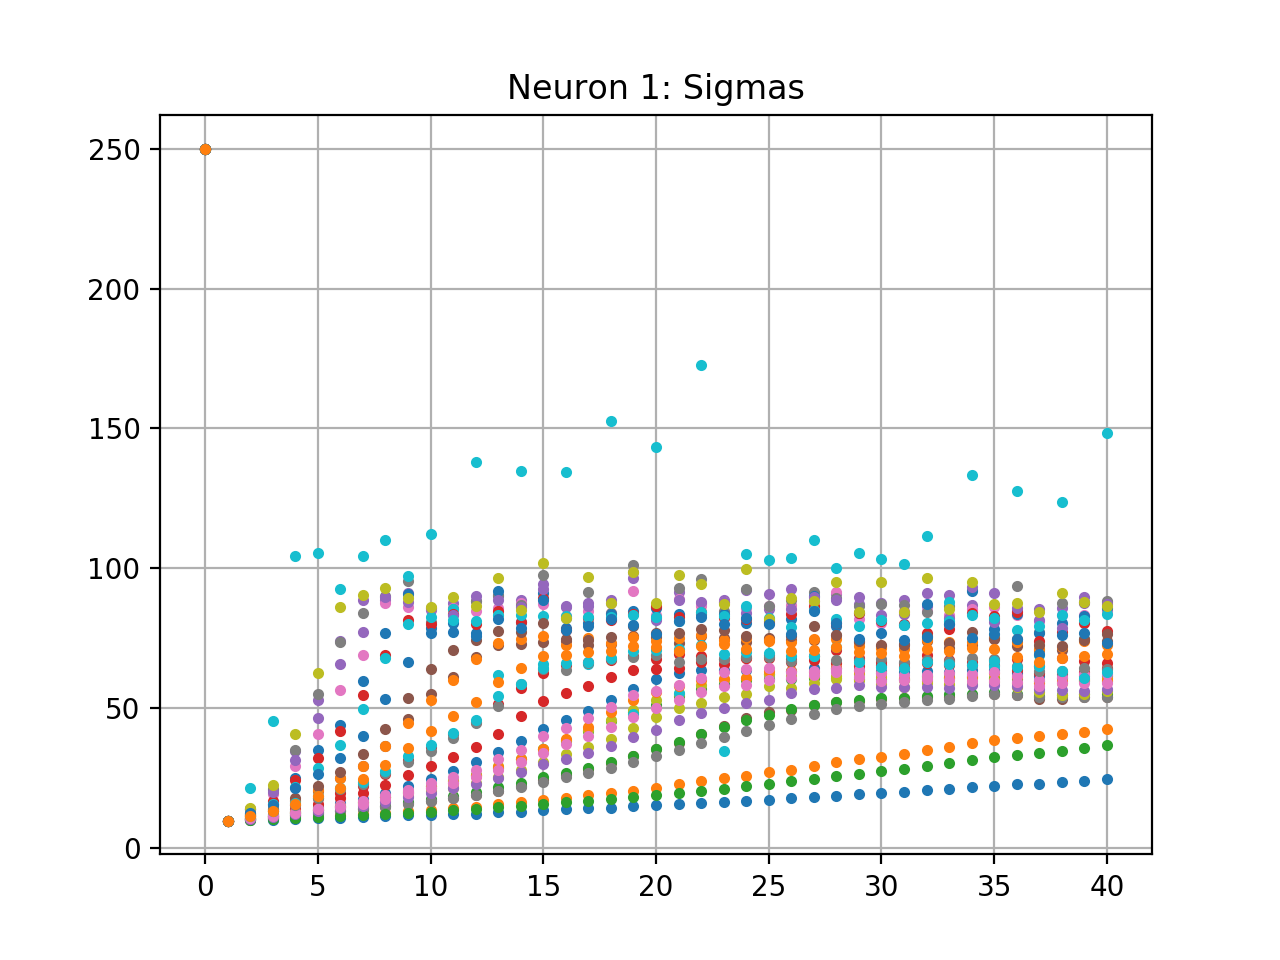

hidden_layers.1.inv_covar
(41, 32, 784)
plotting neurons: [16 31]


<IPython.core.display.Javascript object>


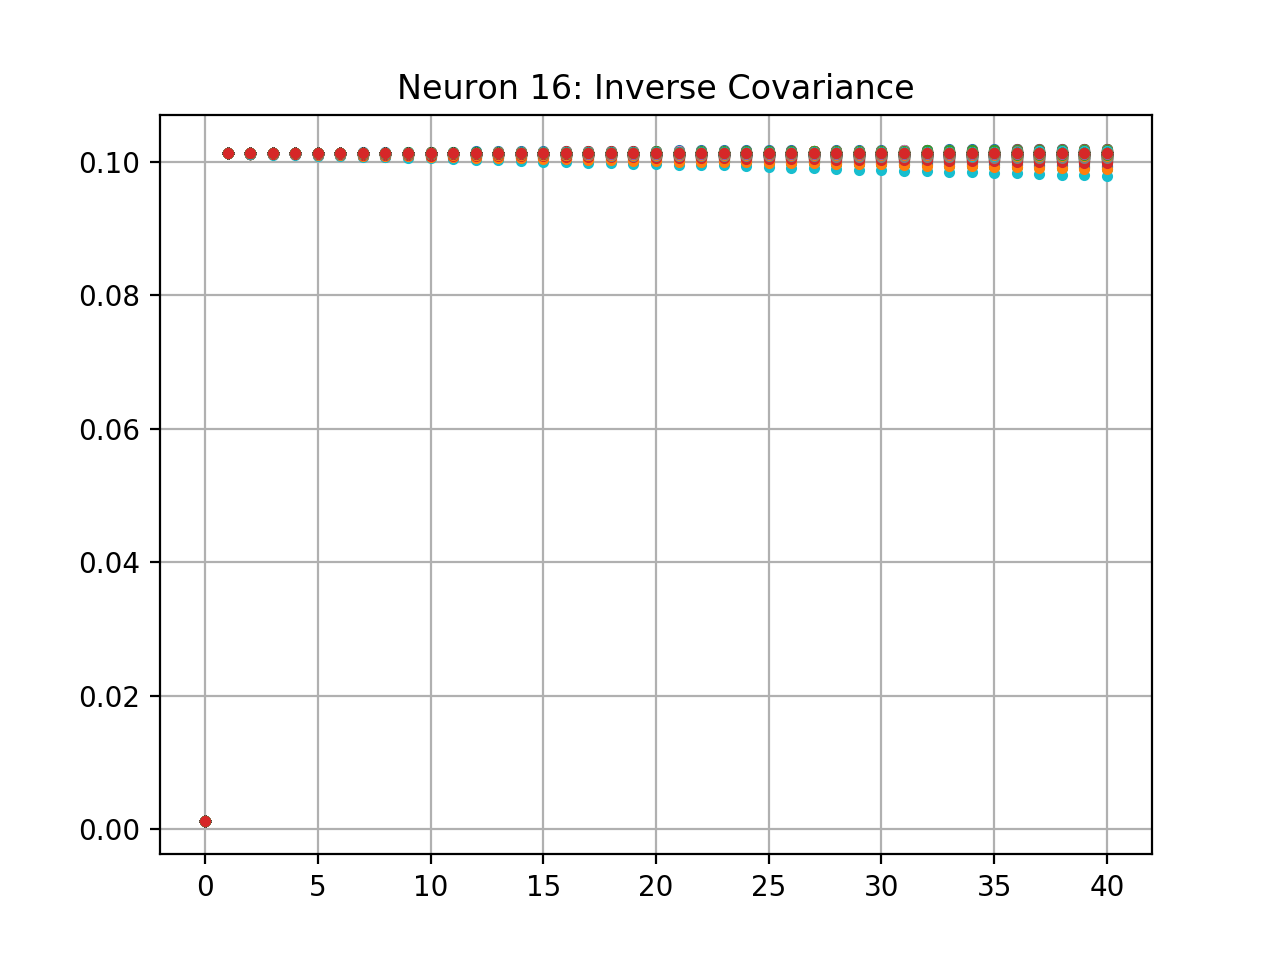

<IPython.core.display.Javascript object>


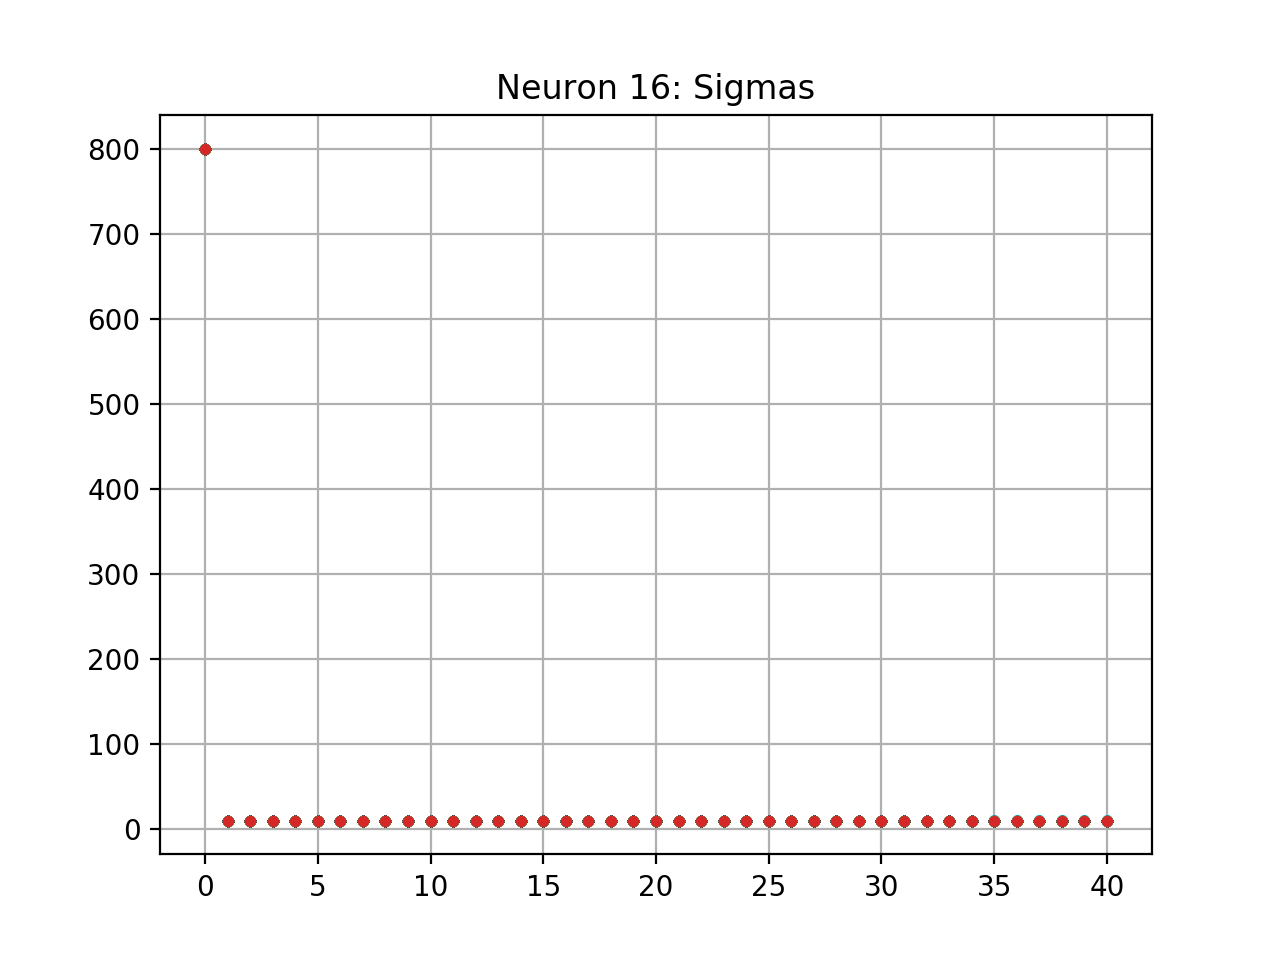

<IPython.core.display.Javascript object>


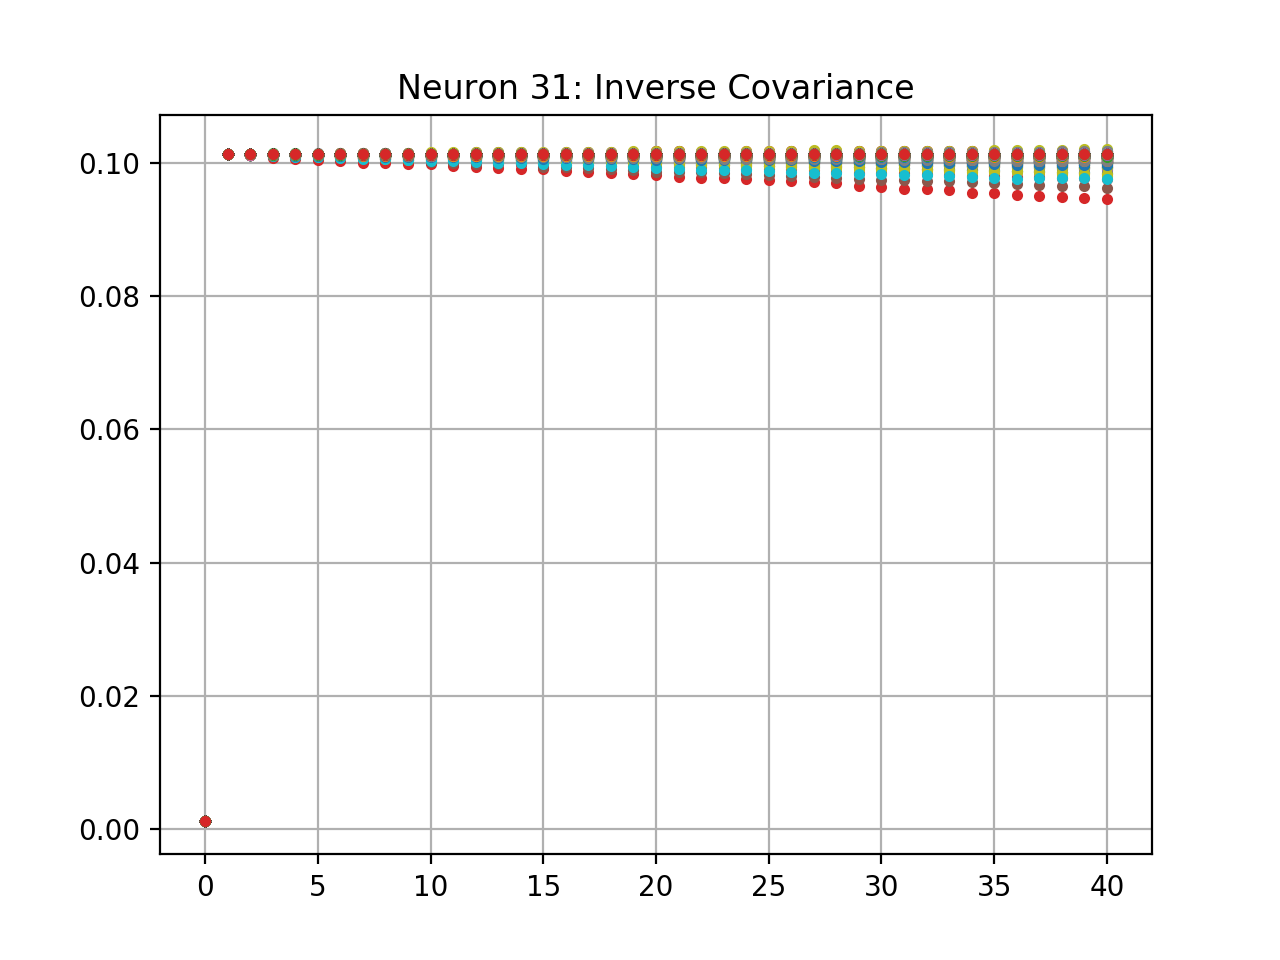

<IPython.core.display.Javascript object>


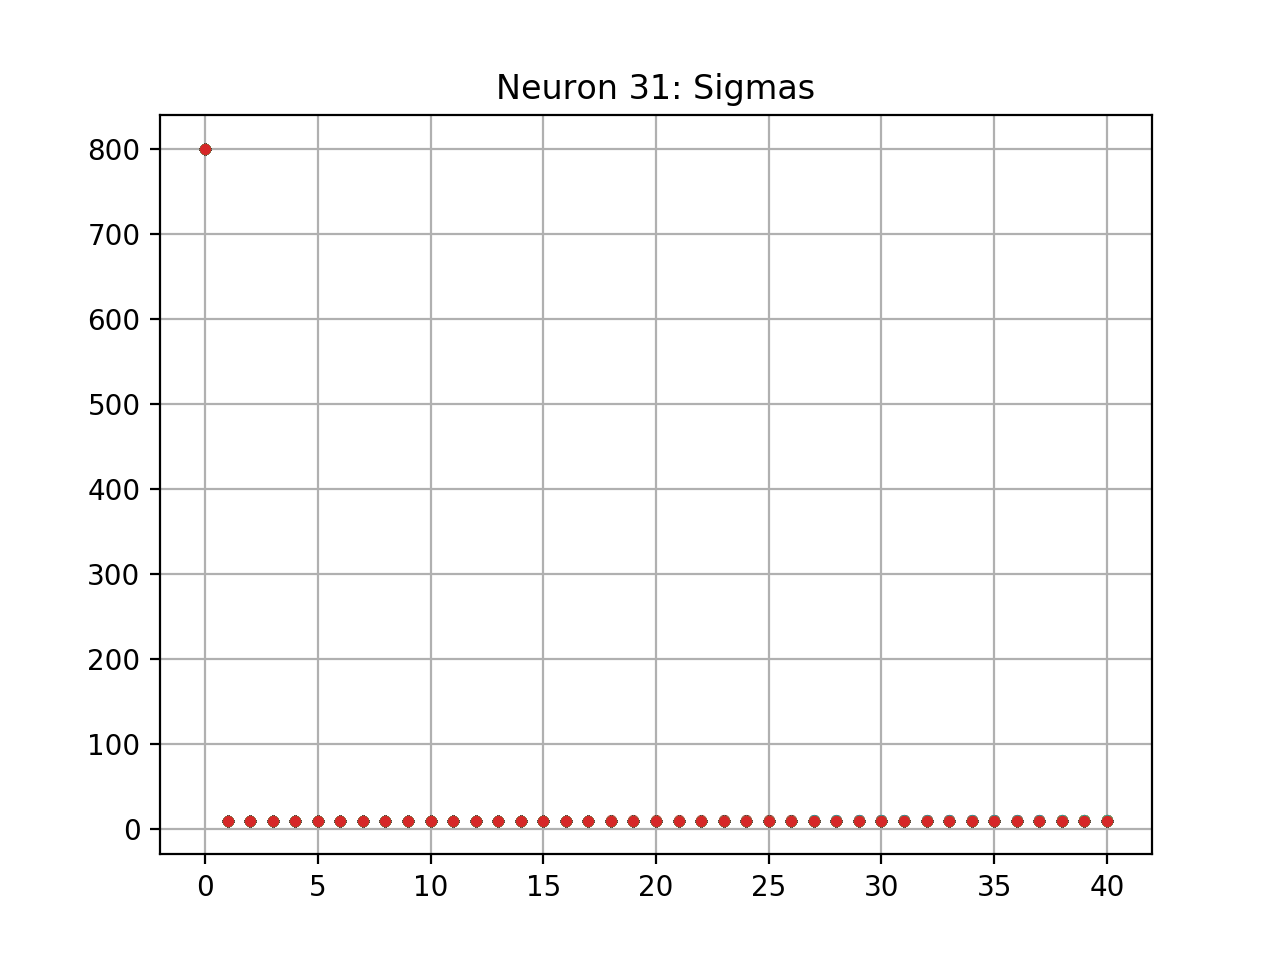

hidden_layers.4.inv_covar
(41, 32, 32)
plotting neurons: [10 19]


<IPython.core.display.Javascript object>


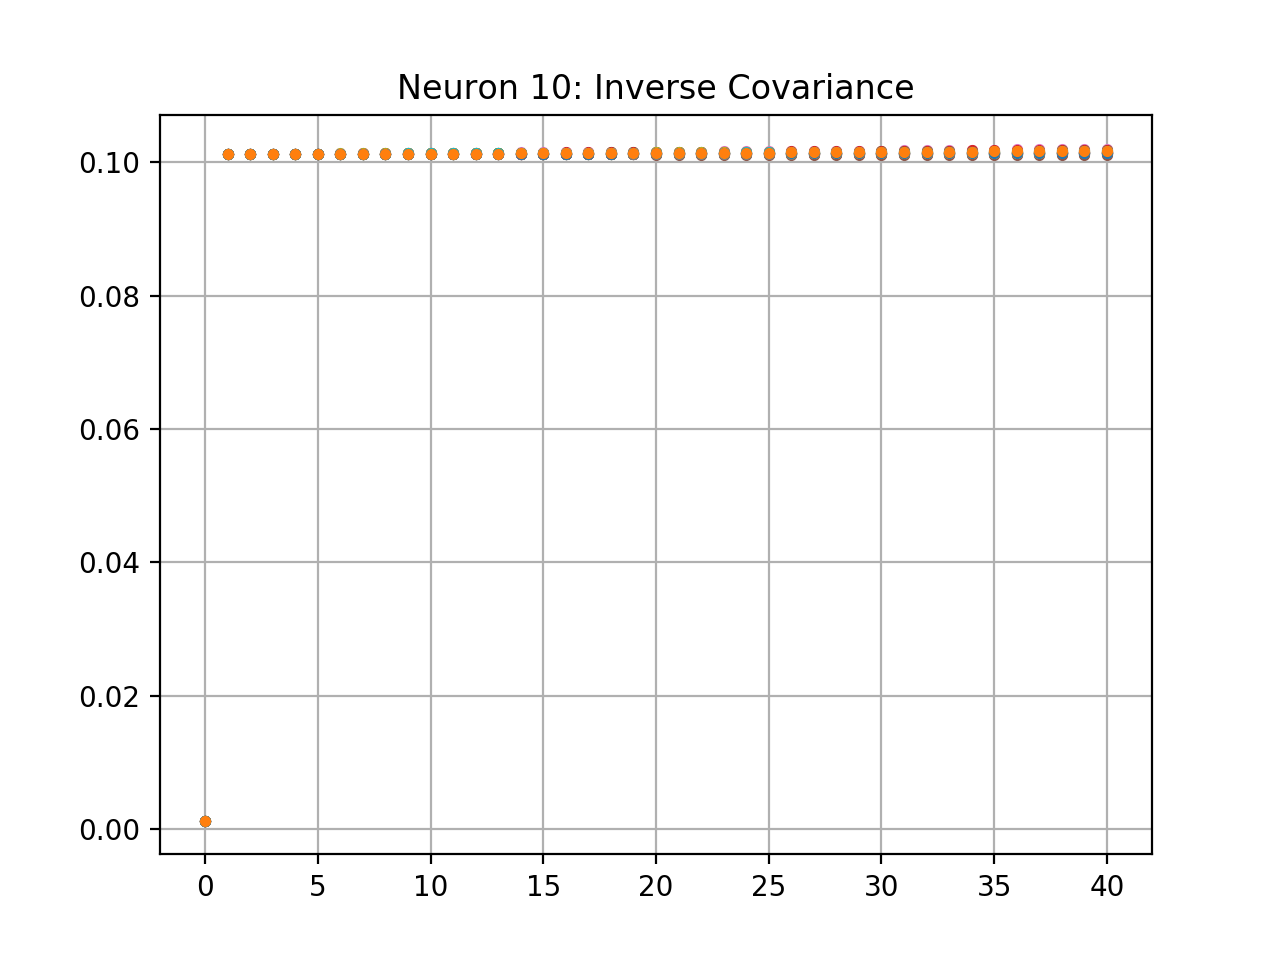

<IPython.core.display.Javascript object>


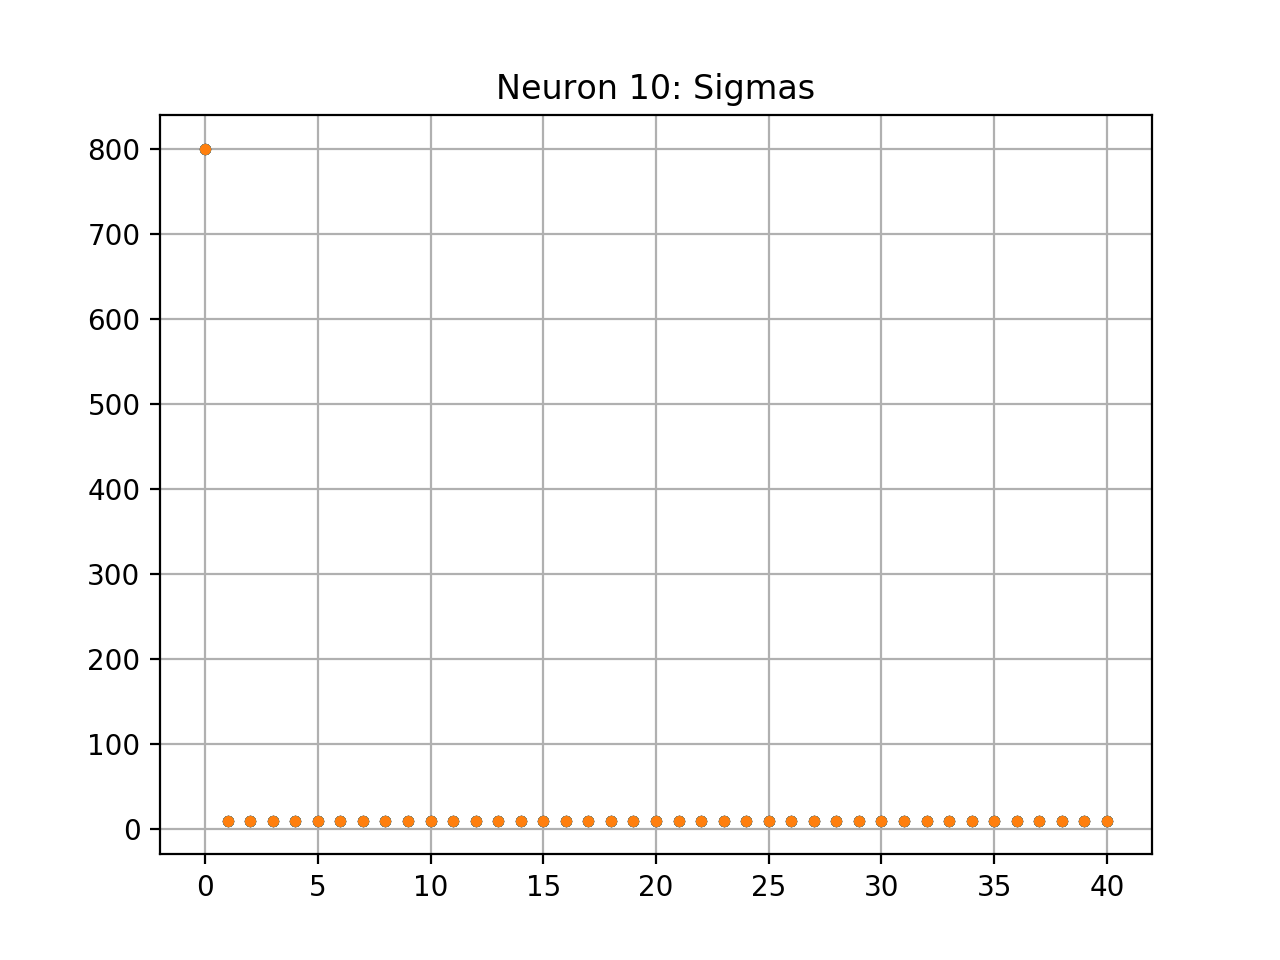

<IPython.core.display.Javascript object>


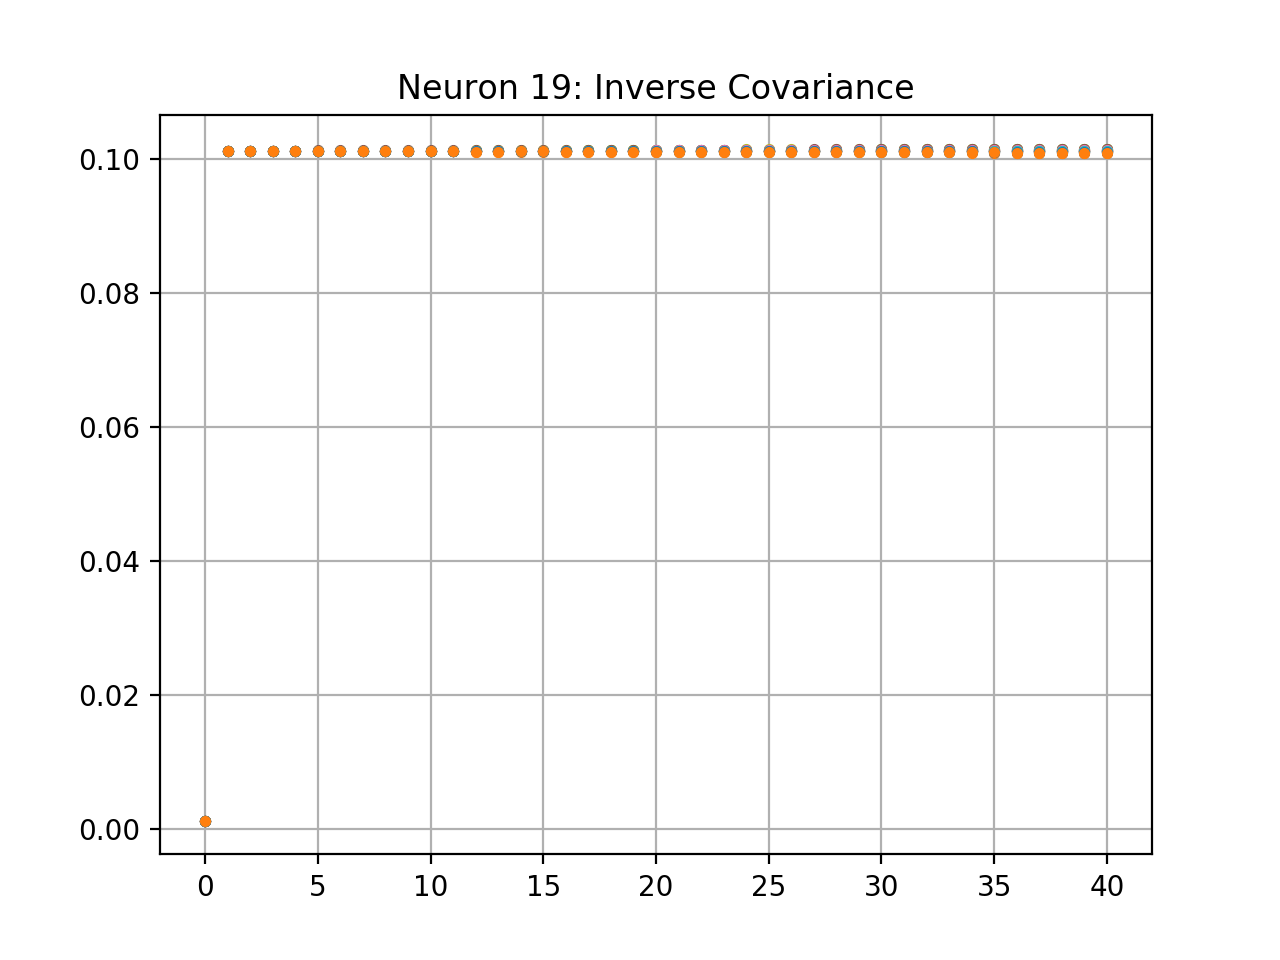

<IPython.core.display.Javascript object>


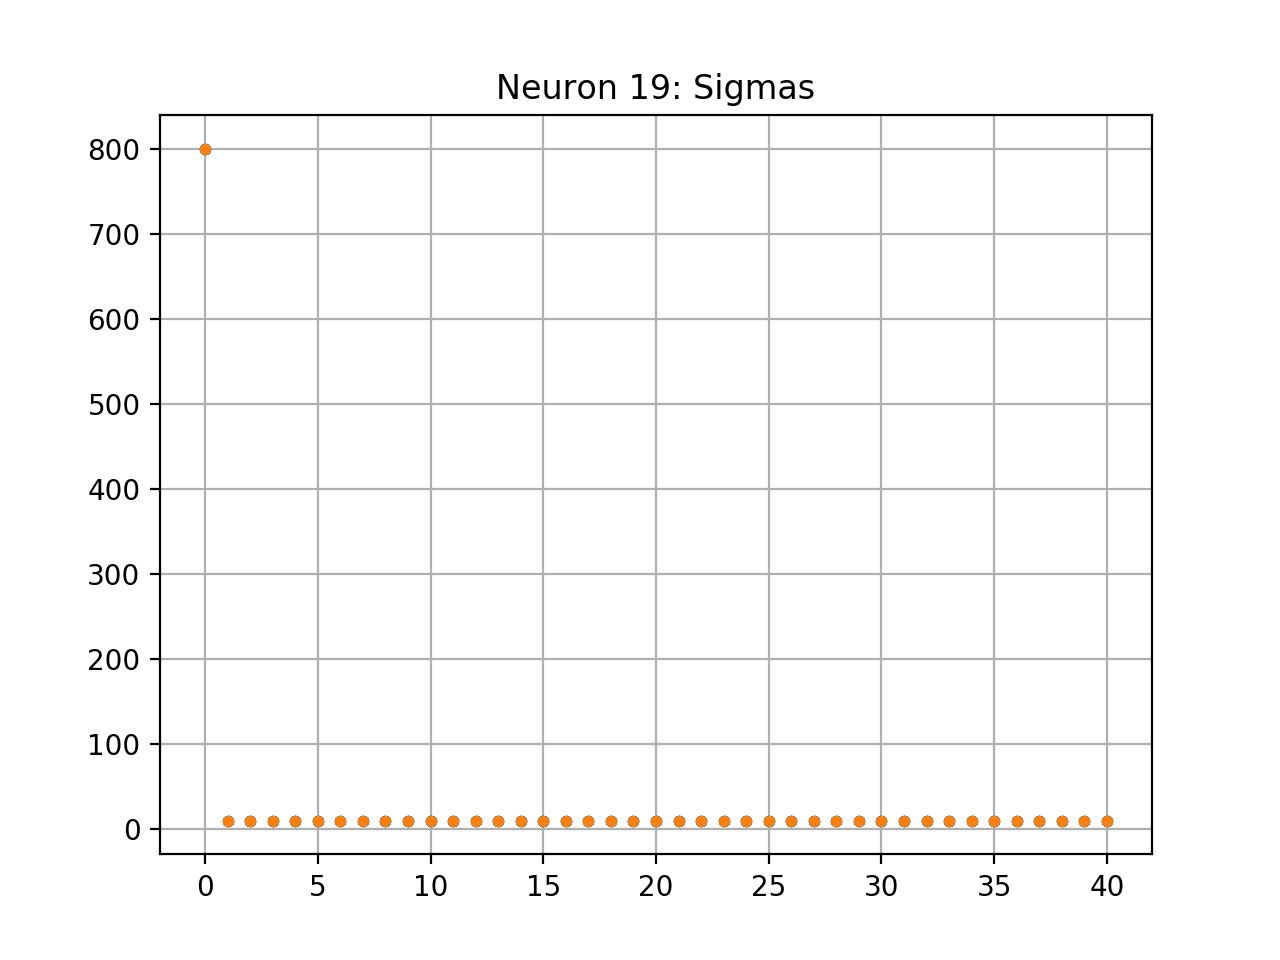

In [27]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'

history_to_plot = converted_train_res['histories']

for k in history_to_plot.keys():
    if 'inv_covar' in k:
        print(k)
        s = history_to_plot[k].shape
        print(s)
        neurons =  np.random.choice(range(s[1]),2, replace=False)
        print("plotting neurons:", neurons)
        if covar_type == 'diag':
            # for each neuron
            for i in neurons:
                plt.plot(history_to_plot[k][:,i].reshape(s[0],np.prod(s[2:])), marker='.', linestyle=' ')
                plt.title('Neuron {}: Inverse Covariance'.format(i))
                plt.grid()
                plt.show()
                
                plt.plot(1.0/history_to_plot[k][:,i].reshape(s[0],np.prod(s[2:])), marker='.', linestyle=' ')
                plt.title('Neuron {}: Sigmas'.format(i))
                plt.grid()
                plt.show()
        
        elif covar_type == 'full':
            # plot trace of each neuron
            for i in neurons:
                # plot trace
                trace = [np.einsum('ik,ik->', p, p) for p in history_to_plot[k][:,i]]
                plt.plot(trace, marker='.', linestyle=' ')
            plt.title('Neuron{}: Trace'.format(i))
            plt.grid()
            plt.show()
        
        
        else:
            # covar_type == 'sphere'
            plt.plot(history_to_plot[k], marker='.', linestyle=' ',)
            plt.title('Inverse Covariance')
            plt.grid()
            plt.show()
            
            plt.plot(1.0/history_to_plot[k], marker='.', linestyle=' ')
            plt.title('Sigma')

            plt.grid()
            plt.show()

hidden_layers.4.centers
plotting neurons: [18  2]


<IPython.core.display.Javascript object>


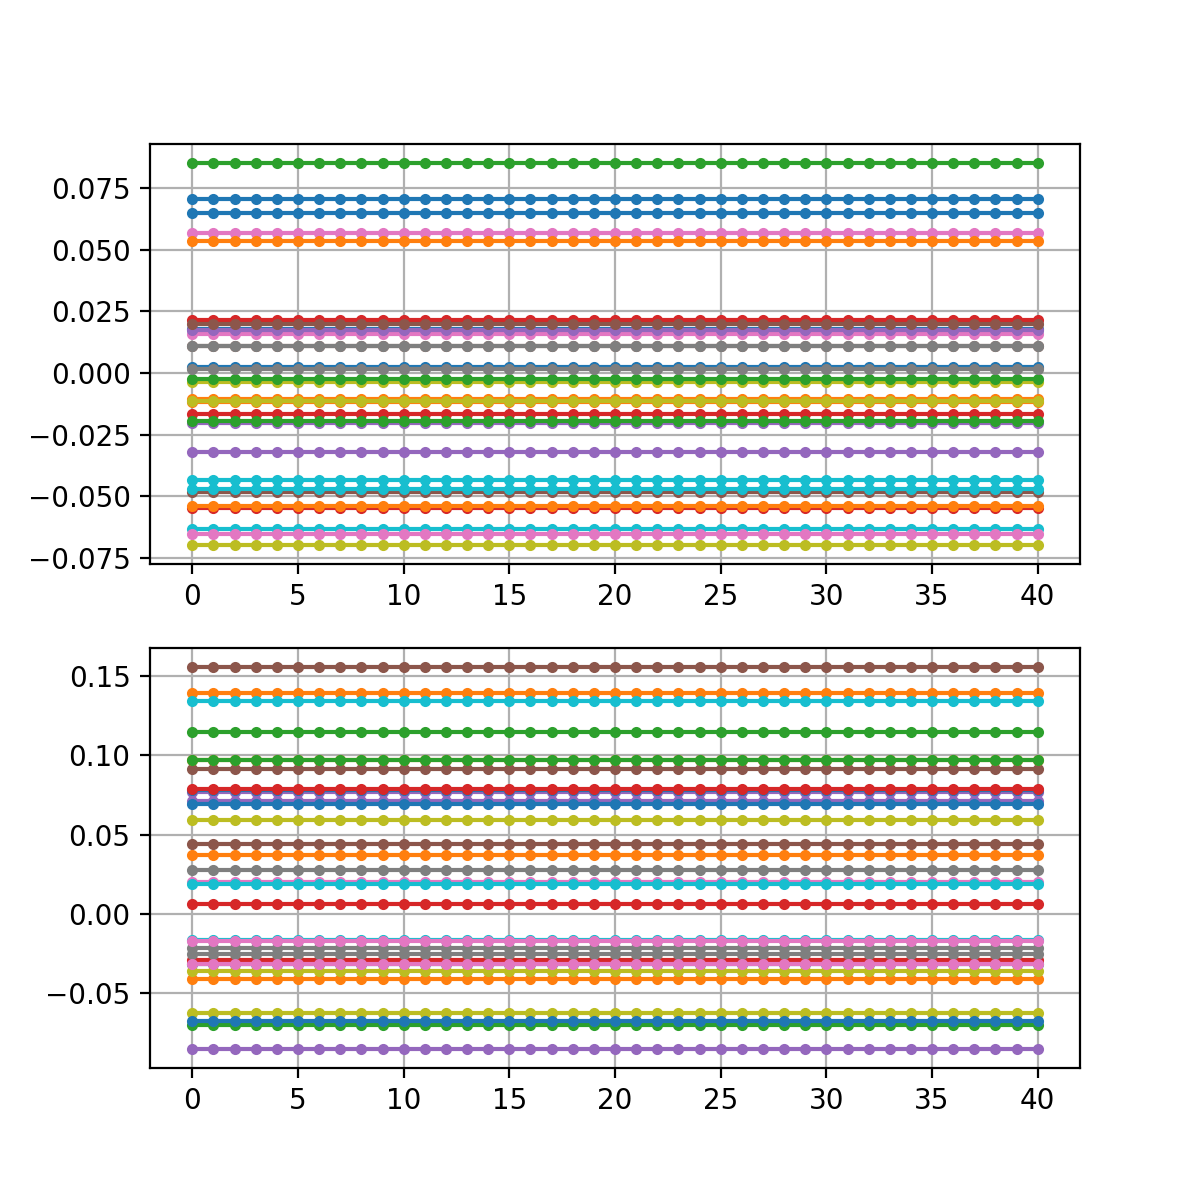

hidden_layers.1.centers
plotting neurons: [25 13]


<IPython.core.display.Javascript object>


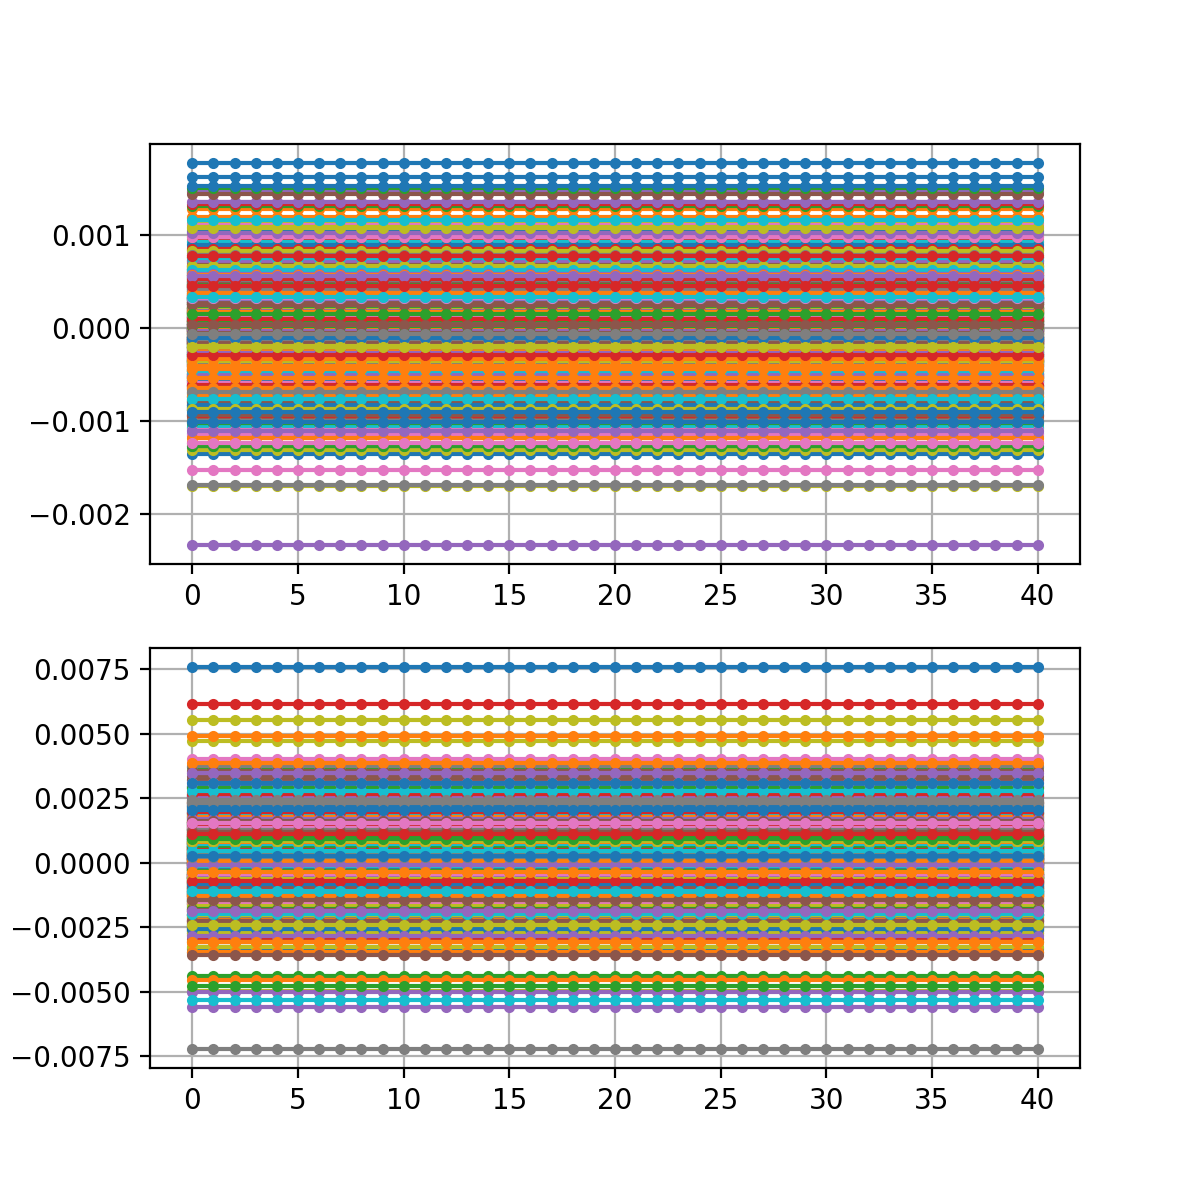

fl.centers
plotting neurons: [3 7]


<IPython.core.display.Javascript object>


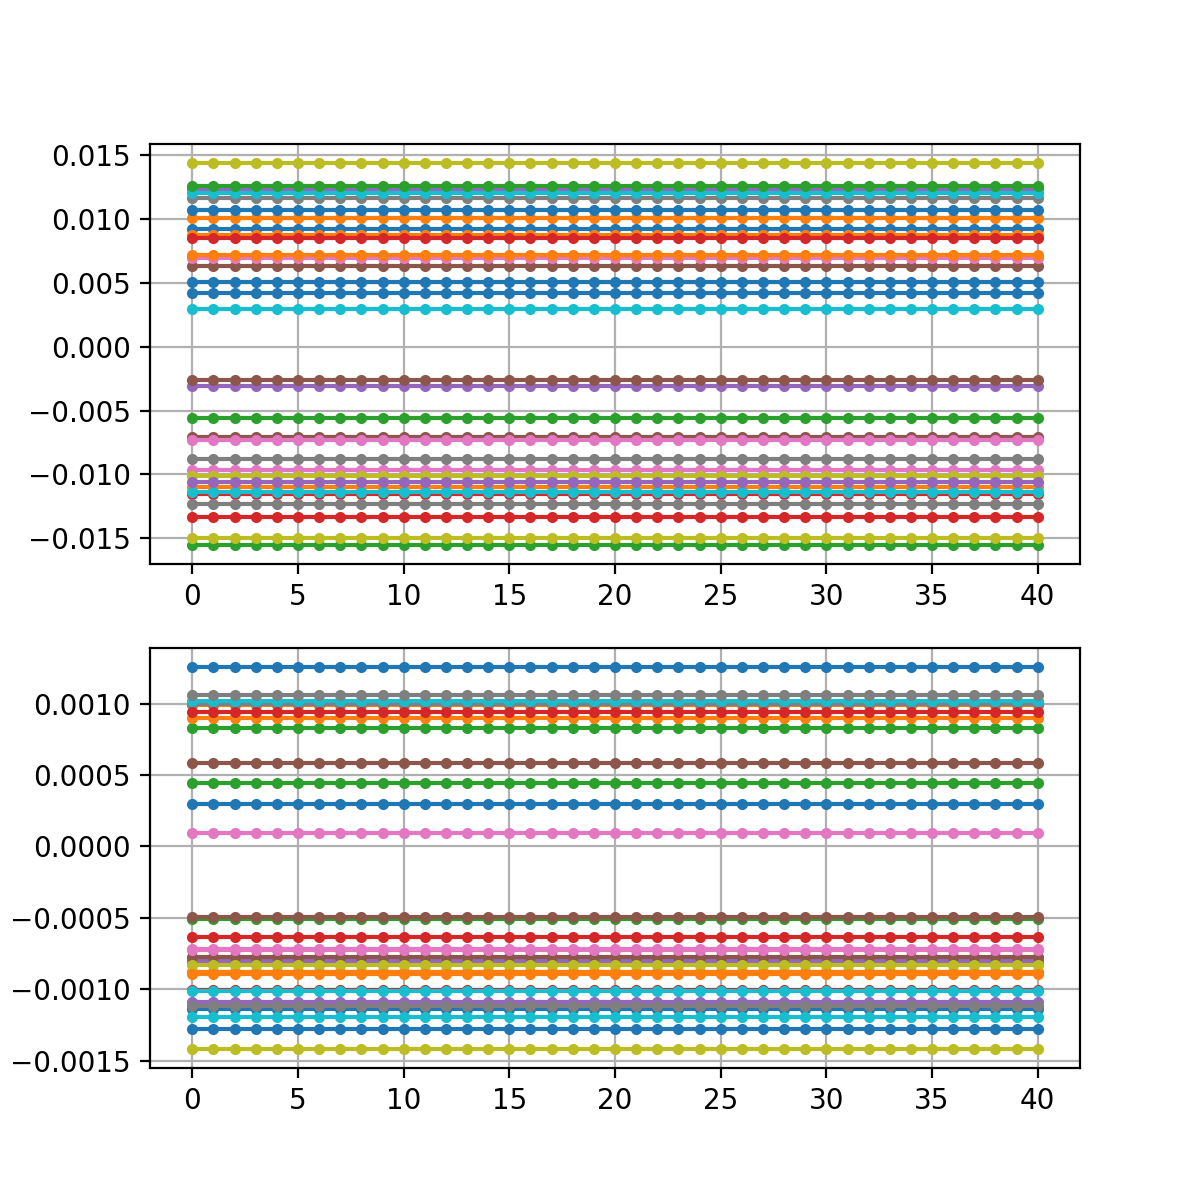

In [28]:
# plot centers history for only some hidden layer neuron

for k in converted_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 2 random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(converted_train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = converted_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()